In [51]:
import pandas as pd
import json

from Levenshtein import distance, hamming, jaro, ratio, setratio 

def compare(voc_one, voc_two, suffix=''):
    storage = {'levenshtein':[],
               'ratio':[]}
    result = {}
    for string1 in voc_one:
        for string2 in voc_two:
            storage['levenshtein'].append(distance(string1, string2))
            storage['ratio'].append(ratio(string1, string2))
    result = {f'levenshtein-mean_{suffix }': sum(storage['levenshtein'])/len(storage['levenshtein']),
              f'ratio-mean_{suffix}': sum(storage['ratio'])/len(storage['ratio']),
              f'set-ratio_{suffix}': setratio(a, b)}
    return result

file = pd.read_excel('https://github.com/Kipre/etude-technique/blob/master/2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx?raw=true')
file = file.loc[file.LANGUE_DOC=="fre"]

results = pd.DataFrame()

for i, row in file.iterrows():
    result = {}
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), row["DESCRIPTEURS"].split(";")))
    else:
        descriptors = []
    agris = list(map(lambda x: x.strip(), row["AGRIS"].split(";")))
    
    xml = pdf_to_xml(pdf)
    try:
        text_json = extract_entities(xml)
    except:
        print('Failed to process xml', xml[:100])
        continue
    try:
        text = json.loads(text_json)
    except:
        print(text_json)
        continue
    entities = [part["rawName"].strip() for part in text["entities"]]
    categories = [part["category"].strip() for part in text["global_categories"]]
    result = {'pdf': pdf}
    for combination, (a, b) in zip(['des-ent', 'des-cat', 
                                    'agr-ent', 'agr-cat'],
                                   [(descriptors, entities),
                                    (descriptors, categories),
                                    (agris, entities),
                                    (agris, categories)]):
        result = {**result, **compare(a, b, suffix=combination)}
    result['descriptors'] = '; '.join(descriptors)
    result['agris'] = '; '.join(agris)
    result['entities'] = '; '.join(entities)
    result['categories'] = '; '.join(categories)
    results = pd.concat([results, pd.DataFrame(result, index=[i])])
    else:
        print('not doing')

    if i == 10:
        break

results


not doing
not doing
not doing
The sent query is invalid. null
not doing
not doing
Failed to process xml [TIMEOUT] PDF to XML conversion timed out
not doing
not doing
The upstream server is timing out

not doing
Failed to process xml <?xml version="1.0" encoding="UTF-8"?>
<TEI xml:space="preserve" xmlns="http://www.tei-c.org/ns/1.0"


KeyboardInterrupt: ignored

In [55]:
results

,pdf,levenshtein-mean_des-ent,ratio-mean_des-ent,set-ratio_des-ent,levenshtein-mean_des-cat,ratio-mean_des-cat,set-ratio_des-cat,levenshtein-mean_agr-ent,ratio-mean_agr-ent,set-ratio_agr-ent,levenshtein-mean_agr-cat,ratio-mean_agr-cat,set-ratio_agr-cat,descriptors,agris,entities,categories
0,http://agritrop.cirad.fr/551172/1/document_551...,12.147436,0.269117,0.021440,22.666667,0.233000,0.185721,29.794872,0.245425,0.014138,28.041667,0.332543,0.212212,Élevage; Cameroun; Cameroun nord,Elevage - Considérations générales; Sociologie...,Cameroun; mbororo; cheptel bovin; mbororo; séd...,Doctrine militaire; Langue de Saint-Christophe...
1,http://agritrop.cirad.fr/555609/1/document_555...,15.929697,0.213328,0.042607,17.657143,0.261493,0.304220,32.284848,0.222619,0.006535,28.857143,0.319445,0.127119,Clone; système d'aide à la décision; Méthodolo...,Génétique et amélioration des plantes,caoutchouc naturel; hévéa; Hevea brasiliensis;...,1999 en science-fiction; Indonésie; Exploratio...
2,http://agritrop.cirad.fr/555932/1/document_555...,14.901124,0.213366,0.008713,17.375000,0.245345,0.253968,18.029213,0.243039,0.002760,18.000000,0.332735,0.172549,Culture maraîchère; Bénin,Culture des plantes,Mission Maraîchage Objectif; Recherche Dévelop...,Fongicide; Lauréat du prix Nobel de la paix; N...
4,http://agritrop.cirad.fr/555971/1/document_555...,19.686364,0.277175,0.116577,22.458333,0.259378,0.354438,21.090909,0.293602,0.017241,21.333333,0.320849,0.146520,Trichogramma chilonis; Saccharum officinarum; ...,Ravageurs des plantes,trichogrammes; trichogrammes; BIOTOP; Ephestia...,Personnalité liée à Toulouse; La Réunion; Memb...
19,http://agritrop.cirad.fr/556626/1/document_556...,18.756944,0.297222,0.013520,17.666667,0.408030,0.407892,32.962384,0.281282,0.006183,29.000000,0.381797,0.409796,science politique; Sociologie; Politique de l'...,Conservation de la nature et ressources fonciè...,Serena; agronomie; sociologie; science politiq...,Commerce électronique; Écologie des écosystème...
21,http://agritrop.cirad.fr/558104/1/document_558...,19.683473,0.296088,0.039558,18.777778,0.354319,0.408294,23.138655,0.307179,0.021570,19.000000,0.401352,0.366897,Recherche agronomique; Système d'information; ...,Documentation et information; Recherche agrono...,développement économique; aide à la décision; ...,Terminologie de l'informatique; Exploration de...
23,http://agritrop.cirad.fr/557835/1/document_557...,12.641622,0.252446,0.060815,16.583333,0.277988,0.258716,17.882979,0.281298,0.005820,18.666667,0.353987,0.217391,Culture fruitière; Culture maraîchère; Musa; R...,Ravageurs des plantes,travaux pratiques; acariens prédateurs; verger...,Initiative citoyenne; Arbre fruitier; Peintre ...
24,http://agritrop.cirad.fr/555988/1/document_555...,13.348066,0.265049,0.018480,14.222222,0.325794,0.349927,44.765193,0.208056,0.010593,44.000000,0.240486,0.254286,Analyse de système; Sociologie; Entraide agricole,"Travail et emploi; Organisation, administratio...",France; ensilage; vendanges; cidre; pays du Su...,Histoire sociale; Symbole de la Normandie; Sén...
25,http://agritrop.cirad.fr/557418/1/document_557...,22.116788,0.206804,0.035801,22.333333,0.285199,0.287223,26.688869,0.207619,0.013849,26.500000,0.271026,0.289116,Méthode d'élevage; Gestion du sol; Projet de d...,Systèmes et modes de culture; Façons culturale...,Executive Summary This; CRSP; SANREM; NGO AVSF...,Cambodge; Album certifié disque de platine au ...
29,http://agritrop.cirad.fr/555434/1/document_555...,15.271255,0.259879,0.142464,16.561404,0.288309,0.296993,19.517751,0.262661,0.024755,19.666667,0.295414,0.323068,Terre cultivée; Rendement des cultures; Change...,Economie et politique agricoles; Economie de l...,Afrique centrale; recherche appliquée; Afrique...,Groupe de musique des années 2010; Capitale en...


Levenshtein distance lower is better


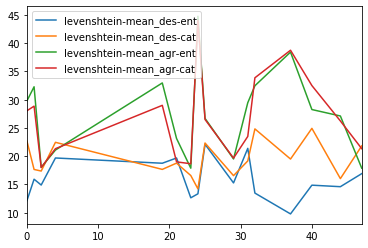

In [53]:
print('Levenshtein distance lower is better')
results[['levenshtein-mean_des-ent', 'levenshtein-mean_des-cat', 'levenshtein-mean_agr-ent', 'levenshtein-mean_agr-cat']].plot()

Ratios higher is better


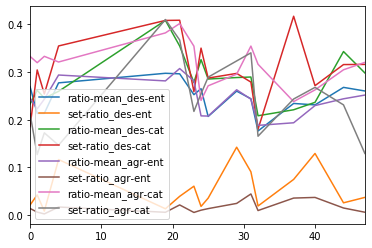

In [54]:
print('Ratios higher is better')
results[['ratio-mean_des-ent', 'set-ratio_des-ent', 'ratio-mean_des-cat', 
         'set-ratio_des-cat', 'ratio-mean_agr-ent', 'set-ratio_agr-ent', 
         'ratio-mean_agr-cat', 'set-ratio_agr-cat']].plot()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


x = np.random.poisson(lam =3, size=100)
y = np.random.choice(["S{}".format(i+1) for i in range(6)], size=len(x))
df = pd.DataFrame({"Scenario":y, "LMP":x})

fig, axes = plt.subplots()

axes.violinplot(dataset = [result[''].values,
                           df[df.Scenario == 'S2']["LMP"].values,
                           df[df.Scenario == 'S3']["LMP"].values,
                           df[df.Scenario == 'S4']["LMP"].values,
                           df[df.Scenario == 'S5']["LMP"].values,
                           df[df.Scenario == 'S6']["LMP"].values ] )

axes.set_title('Day Ahead Market')
axes.yaxis.grid(True)
axes.set_xlabel('Scenario')
axes.set_ylabel('LMP ($/MWh)')

plt.show()

## Agrovoc reconciliation

In [1]:
from agrovoc import *
from agrovoc_utils import *
from rdflib import Graph

In [2]:
# takes about 20 minutes to run

g = Graph()
a = Agrovoc(g)

Now loading the dictionary...


  0%|          | 16/36938 [00:00<10:25, 59.04it/s]

Now indexing the dictionary...


100%|██████████| 36938/36938 [04:31<00:00, 136.06it/s]


In [9]:
a.find_with_agrovoc('Cameroun')

{('http://aims.fao.org/aos/agrovoc/c_1229', 'Cameroun')}

In [13]:
import pandas as pd

file = pd.read_excel('https://github.com/Kipre/etude-technique/blob/master/2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx?raw=true')
file = file.loc[file.LANGUE_DOC=="fre"]


for i, data in file['AGRIS'].iteritems():
    if type(data) == str:
        concepts = list(map(lambda x: x.strip(), data.split(';')))
        print(concept, a.find_with_agrovoc(concept))
    if i > 30:
        break


Elevage - Considérations générales set()
Sociologie rurale {('http://aims.fao.org/aos/agrovoc/c_6707', 'Sociologie rurale')}
sécurité sociale {('http://aims.fao.org/aos/agrovoc/c_7133', 'sécurité sociale')}
Economie {('http://aims.fao.org/aos/agrovoc/c_2481', 'Economie'), ('http://aims.fao.org/aos/agrovoc/c_2479', 'Economie')}
politique foncières {('http://aims.fao.org/aos/agrovoc/c_195', 'politique foncières')}
Génétique {('http://aims.fao.org/aos/agrovoc/c_3222', 'Génétique')}
amélioration des plantes {('http://aims.fao.org/aos/agrovoc/c_5956', 'amélioration des plantes')}
Culture des plantes {('http://aims.fao.org/aos/agrovoc/c_1972', 'Culture des plantes')}
Organismes nuisibles des animaux set()
Ravageurs des plantes {('http://aims.fao.org/aos/agrovoc/c_16196', 'Ravageurs des plantes')}
Economie {('http://aims.fao.org/aos/agrovoc/c_2481', 'Economie'), ('http://aims.fao.org/aos/agrovoc/c_2479', 'Economie')}
politique du développement {('http://aims.fao.org/aos/agrovoc/c_2228', 'poli

In [21]:
for i, data in file['AGRIS'].iteritems():
    if type(data) == str:
        concepts = re.split(" et |;|,|-", data)
        print(concepts)
        for concept in concepts:
                print(concept, a.find_with_agrovoc(concept))
    if i > 30:
        break

['Elevage ', ' Considérations générales', ' Sociologie rurale', 'sécurité sociale', ' Economie', 'politique foncières']
Elevage  set()
 Considérations générales set()
 Sociologie rurale set()
sécurité sociale {('http://aims.fao.org/aos/agrovoc/c_7133', 'sécurité sociale')}
 Economie set()
politique foncières {('http://aims.fao.org/aos/agrovoc/c_195', 'politique foncières')}
['Génétique', 'amélioration des plantes']
Génétique {('http://aims.fao.org/aos/agrovoc/c_3222', 'Génétique')}
amélioration des plantes {('http://aims.fao.org/aos/agrovoc/c_5956', 'amélioration des plantes')}
['Culture des plantes']
Culture des plantes {('http://aims.fao.org/aos/agrovoc/c_1972', 'Culture des plantes')}
['Organismes nuisibles des animaux']
Organismes nuisibles des animaux set()
['Ravageurs des plantes']
Ravageurs des plantes {('http://aims.fao.org/aos/agrovoc/c_16196', 'Ravageurs des plantes')}
['Economie', 'politique du développement', ' Sociologie rurale', 'sécurité sociale', ' Méthodes de recherche

In [38]:
import json
import functools


def to_agrovoc(concepts):
    result = set()
    for concept in concepts:
        result = result.union(a.find_with_agrovoc(concept))
    return result

def intersection(set1, set2):
    inter_concept = set()
    for concept1 in set1 : 
        for concept2 in set2 : 
            if concept1[0] == concept2[0]:
                inter_concept.add(concept1)
                break
    return inter_concept           

class Callback:
    def __init__(self, message=""):
        self.average_accuracy=0
        self.average_precsision=0
        self.average_recovery=0
        self.average_nb_entities=0
        self.message = message
        self.examples = 0
        self.memory = []
        self.text=""
    def update(self, set1, List):
        set2 = to_agrovoc(List)
        self.text += ' '.join([word.replace(' ', '_') for _, word in set2])
        recovery = len(set2)/len(List)if len(List)>0 else 0
        res = intersection(set1, set2)
        accuracy = len(res)/len(set1)if len(set1)>0 else 0
        precsision = len(res)/len(set2)if len(set2)>0 else 0
        self.memory.append([accuracy, precsision, recovery])
        self.average_accuracy = (self.average_accuracy * self.examples + accuracy)/(self.examples + 1)
        self.average_nb_entities = (self.average_nb_entities * self.examples + len(List))/(self.examples + 1)
        self.average_precsision = (self.average_precsision * self.examples + precsision)/(self.examples + 1)
        self.average_recovery = (self.average_recovery * self.examples + recovery)/(self.examples + 1)
        self.examples += 1
        return("{} : {} , {} , {}".format(self.message, accuracy, precsision, recovery))
        

file = pd.read_excel('https://github.com/Kipre/etude-technique/blob/master/2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx?raw=true')
file = file.loc[file.LANGUE_DOC=="fre"]

results = pd.DataFrame()
cagro = Callback("Agrovoc")
for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), row["DESCRIPTEURS"].split(";")))
    else:
        descriptors = []
        continue
    #agris = list(map(lambda x: x.strip().split(" et "), row["AGRIS"].split(";")))
    #agris = list(functools.reduce(lambda x, y: x + y, agris))
    metadata = to_agrovoc(descriptors)
    
    xml = pdf_to_xml(pdf)
    try:
        text_json = extract_entities(xml)
    except:
        print('Failed to process xml', xml[:100])
        continue
    try:
        text = json.loads(text_json)
    except:
        print(text_json)
        continue
    entities = [part["rawName"].strip() for part in text["entities"]]
    categories = [part["category"].strip() for part in text["global_categories"]]
    ent_and_cat = entities + categories
    #ner_metadata = to_agrovoc(entities).union(to_agrovoc(categories))
    
    print(cagro.update(metadata, ent_and_cat))
  
    if i > 100:
        break
print(cagro.average_accuracy)



Agrovoc : 0.5 , 0.023255813953488372 , 0.19907407407407407
Agrovoc : 0.4 , 0.05405405405405406 , 0.21511627906976744
Agrovoc : 1.0 , 0.016 , 0.27839643652561247
Agrovoc : 0.75 , 0.23076923076923078 , 0.21311475409836064
The sent query is invalid. null
Agrovoc : 1.0 , 0.05194805194805195 , 0.13298791018998274
Agrovoc : 0.3333333333333333 , 0.043478260869565216 , 0.1885245901639344
Agrovoc : 0.625 , 0.11363636363636363 , 0.23036649214659685
Agrovoc : 0.0 , 0.0 , 0.2554347826086957
Agrovoc : 0.1111111111111111 , 0.03225806451612903 , 0.11191335740072202
Failed to process xml [TIMEOUT] PDF to XML conversion timed out
Agrovoc : 0.3157894736842105 , 0.17647058823529413 , 0.19428571428571428
Agrovoc : 1.0 , 0.1 , 0.4444444444444444
Agrovoc : 0.3333333333333333 , 0.02702702702702703 , 0.19072164948453607
Agrovoc : 0.5 , 0.07692307692307693 , 0.30952380952380953
The upstream server is timing out

Agrovoc : 0.25 , 0.15384615384615385 , 0.21311475409836064
Agrovoc : 0.5 , 0.023529411764705882 , 0

In [40]:
file["DESCRIPTEURS"]

0                         Élevage; Cameroun; Cameroun nord
1        Clone; système d'aide à la décision; Méthodolo...
2                                Culture maraîchère; Bénin
3                                                      NaN
4        Trichogramma chilonis; Saccharum officinarum; ...
                               ...                        
12270                                                  NaN
12274                                                  NaN
12283                                                  NaN
12285    Innovation; Manioc; Pratique culturale; Agricu...
12287                                                  NaN
Name: DESCRIPTEURS, Length: 4568, dtype: object

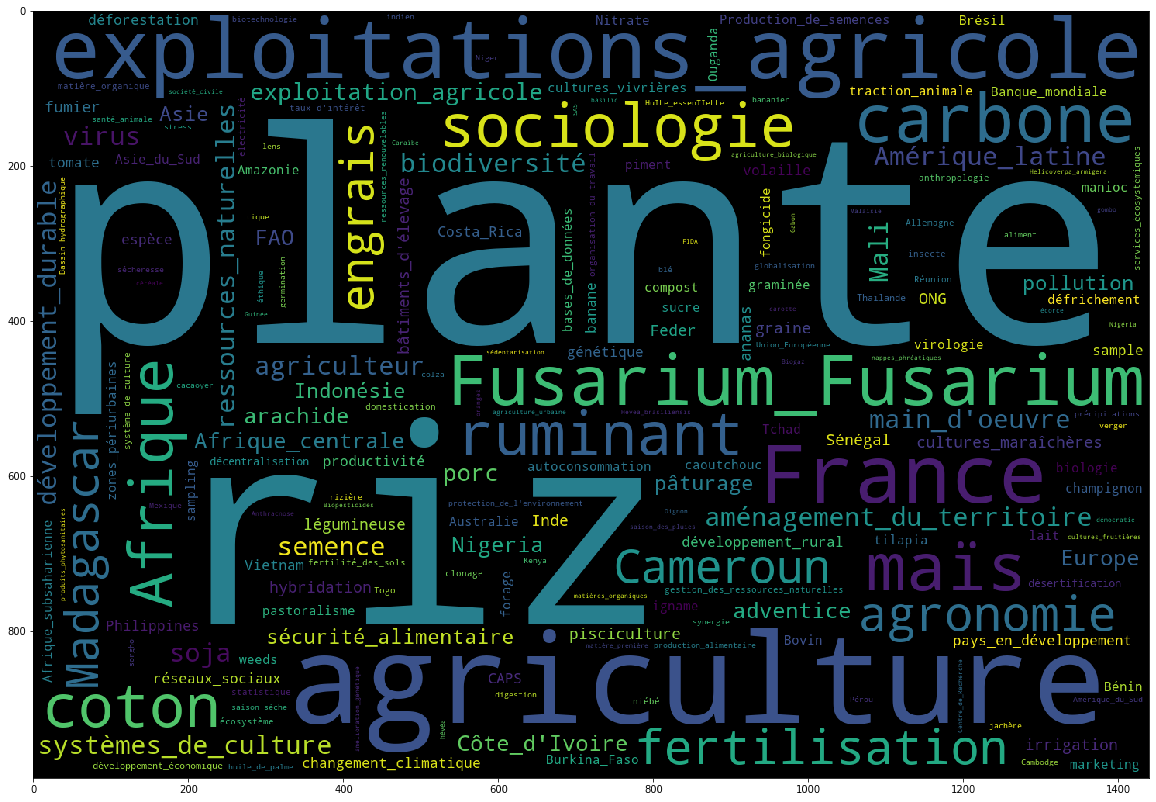

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(WordCloud(width=1440, height=990, margin= 10).generate(cagro.text))

In [28]:
!pip install WordCloud

     |████████████████████████████████| 368kB 1.0MB/s eta 0:00:01
